<a href="https://colab.research.google.com/github/Nada-Elghaweet/Ai-safety-system/blob/Randomforest_IMGS/RandomForestModell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_name = 'VIOLENCE VS NON_VIOLENCE.zip'
extract_path = 'dataset'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(os.listdir(extract_path))


Saving VIOLENCE VS NON_VIOLENCE.zip to VIOLENCE VS NON_VIOLENCE.zip
['VIOLENCE VS NON_VIOLENCE']


In [2]:
import glob

DATA_DIR = 'dataset/VIOLENCE VS NON_VIOLENCE'
CLASSES = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", CLASSES)

def get_image_paths_labels(split):
    X_paths, y_labels = [], []
    for label, cls in enumerate(CLASSES):
        folder = os.path.join(DATA_DIR, split, cls)
        for img_path in glob.glob(os.path.join(folder, '*')):
            X_paths.append(img_path)
            y_labels.append(label)
    return X_paths, y_labels

X_train_paths, y_train = get_image_paths_labels('train')
X_val_paths, y_val = get_image_paths_labels('val')
X_test_paths, y_test = get_image_paths_labels('test')

print(f"Train: {len(X_train_paths)}, Val: {len(X_val_paths)}, Test: {len(X_test_paths)}")


Classes: ['non_violence', 'violence']
Train: 700, Val: 156, Test: 117


In [3]:
import cv2
import numpy as np
from skimage.feature import hog

def extract_features_with_labels(img_paths, labels):
    features, new_labels = [], []
    for path, label in zip(img_paths, labels):
        img = cv2.imread(path)
        img = cv2.resize(img, (64,64))

        # HOG
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)

        # Color histogram
        hist = cv2.calcHist([img],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
        hist = cv2.normalize(hist, hist).flatten()

        # Combine
        feat = np.hstack([hog_feat, hist])

        # Original
        features.append(feat)
        new_labels.append(label)

        # Augmented: horizontal flip
        img_flip = cv2.flip(img, 1)
        gray_flip = cv2.cvtColor(img_flip, cv2.COLOR_BGR2GRAY)
        hog_flip = hog(gray_flip, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
        hist_flip = cv2.calcHist([img_flip],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
        hist_flip = cv2.normalize(hist_flip, hist_flip).flatten()
        features.append(np.hstack([hog_flip, hist_flip]))
        new_labels.append(label)  # duplicate label

    return np.array(features), np.array(new_labels)

# Training features + labels (augmented)
X_train_features, y_train_aug = extract_features_with_labels(X_train_paths, y_train)

# Validation & test features (no augmentation)
def extract_features(img_paths):
    features = []
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (64,64))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
        hist = cv2.calcHist([img],[0,1,2],None,[8,8,8],[0,256,0,256,0,256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(np.hstack([hog_feat, hist]))
    return np.array(features)

X_val_features = extract_features(X_val_paths)
X_test_features = extract_features(X_test_paths)

print("Feature shapes:", X_train_features.shape, X_val_features.shape, X_test_features.shape)

Feature shapes: (1400, 2276) (156, 2276) (117, 2276)


In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_features, y_train_aug)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [5]:
from sklearn.metrics import accuracy_score, classification_report

# Validation
val_pred = rf.predict(X_val_features)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Validation Report:\n", classification_report(y_val, val_pred, target_names=CLASSES))

# Test
test_pred = rf.predict(X_test_features)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Test Report:\n", classification_report(y_test, test_pred, target_names=CLASSES))


Validation Accuracy: 0.717948717948718
Validation Report:
               precision    recall  f1-score   support

non_violence       0.66      0.90      0.76        78
    violence       0.84      0.54      0.66        78

    accuracy                           0.72       156
   macro avg       0.75      0.72      0.71       156
weighted avg       0.75      0.72      0.71       156

Test Accuracy: 0.6153846153846154
Test Report:
               precision    recall  f1-score   support

non_violence       0.31      1.00      0.47        20
    violence       1.00      0.54      0.70        97

    accuracy                           0.62       117
   macro avg       0.65      0.77      0.58       117
weighted avg       0.88      0.62      0.66       117



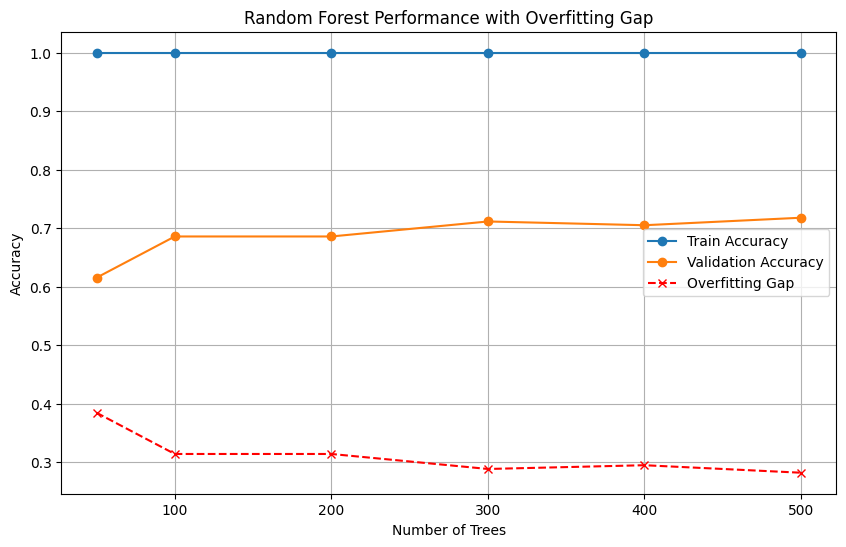

In [6]:
import matplotlib.pyplot as plt

n_estimators_list = [50, 100, 200, 300, 400, 500]
train_scores, val_scores, gaps = [], [], []

for n in n_estimators_list:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )
    rf_temp.fit(X_train_features, y_train_aug)
    train_acc = accuracy_score(y_train_aug, rf_temp.predict(X_train_features))
    val_acc = accuracy_score(y_val, rf_temp.predict(X_val_features))
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    gaps.append(train_acc - val_acc)

plt.figure(figsize=(10,6))
plt.plot(n_estimators_list, train_scores, marker='o', label='Train Accuracy')
plt.plot(n_estimators_list, val_scores, marker='o', label='Validation Accuracy')
plt.plot(n_estimators_list, gaps, marker='x', linestyle='--', color='red', label='Overfitting Gap')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance with Overfitting Gap')
plt.legend()
plt.grid(True)
plt.show()
